# mBuild tutorial: Building an alkane

To begin, we need to provide some import statements

In [1]:
%matplotlib notebook
from visualize import visualize
import mbuild as mb

Now we'll load a CH2 moeity into an mBuild Compound by reading from a PDB structure file. This will create an mBuild `Compound` containing three atoms (C, H, H), as well as two C-H bonds

In [2]:
ch2 = mb.load('ch2.pdb')
ch2

<Compound 3 particles, non-periodic, 2 bonds, id: 4476354800>

<IPython.core.display.Javascript object>


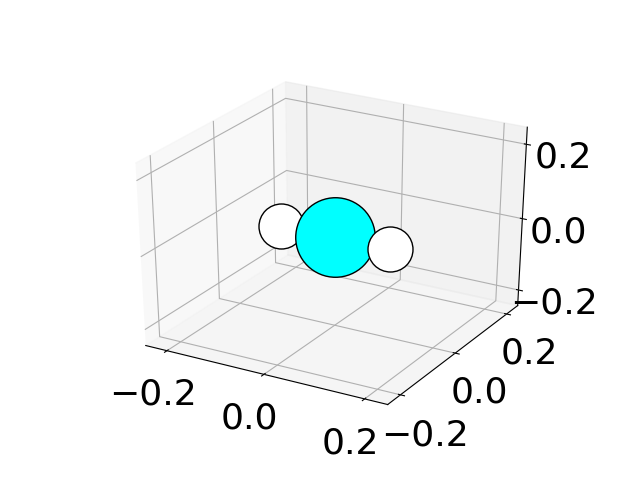

In [3]:
visualize(ch2)

In [4]:
list(ch2.particles())

[<C pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4541943312>,
 <H pos=(-0.1100, 0.0000, 0.0000), 0 bonds, id: 4463382144>,
 <H pos=( 0.1100, 0.0000, 0.0000), 0 bonds, id: 4344412928>]

mBuild `Compound`'s have a (growing) variety of attributes and methods (http://mosdef-hub.github.io/mbuild/data_structures.html).

Here we will use the `particles_by_name` method to grab the carbon atom in our `Compound`.

In [5]:
carbon = list(ch2.particles_by_name('C'))[0]
carbon

<C pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4541943312>

The `Port` class (http://mosdef-hub.github.io/mbuild/data_structures.html#mbuild.port.Port) is used to create ports, essentially dangling bonds, that can be utilized to connect `Compound`'s together and can accept several helpful arguments upon instantiation to orient the port in the desired direction.

Here we will create two ports to add to our CH2 moeity to represent the two dangling bonds. We will orient these in opposite directions (+*y* and -*y*) and shift these from the carbon position by half of a C-C bond length (Note, mBuild uses nanometers as the distance unit).

In [6]:
up_port = mb.Port(anchor=carbon, orientation=[0, 1, 0], separation=0.075)
down_port = mb.Port(anchor=carbon, orientation=[0, -1, 0], separation=0.075)
up_port

<Port 0 particles, non-periodic, 0 bonds, id: 4584309088>

Now we can use the `add` function to add the ports we've just created to our `Compound`. `add` can be used to add `Compound`'s to other `Compound`'s.

In [7]:
ch2.add(up_port, label='up')
ch2.add(down_port, label='down')
ch2.available_ports()

[<Port 0 particles, non-periodic, 0 bonds, id: 4584309088>,
 <Port 0 particles, non-periodic, 0 bonds, id: 4584312112>]

Any part added to a `Compound` can be given an optional, descriptive string `label` for easy referencing. In the above code block, we added the labels `up` and `down` to the two `Port`'s that we added to our CH2 moeity.

In [8]:
ch2['up']

<Port 0 particles, non-periodic, 0 bonds, id: 4584309088>

The mBuild `clone` function is an alternative to `deepcopy` and allows us to create copies of `Compound`'s. (If you are unfamiliar with the concept of a deep copy, here is a description copied from the Python manual: *A deep copy constructs a new compound object and then, recursively, inserts copies into it of the objects found in the original.*)

In [9]:
ch2_copy = mb.clone(ch2)

The `force_overlap` function takes a `Compound` and then rotates and translates it such that two other `Compounds` overlap. Typically, as in the following case, those two other `Compounds` are `Ports` - in our case, `ch2_copy['up']` and `ch2['down']`.

In [10]:
mb.force_overlap(move_this=ch2_copy,
                 from_positions=ch2_copy['up'],
                 to_positions=ch2['down'])

We now have two CH2 moeities bonded together. Next, we'll add these two `Compounds` to a parent `Compound` that we will call `alkane`, which we can visualize or otherwise manipulate.

In [11]:
alkane = mb.Compound()
alkane.add(ch2, label='ch2[$]')
alkane.add(ch2_copy, label='ch2[$]')

<IPython.core.display.Javascript object>


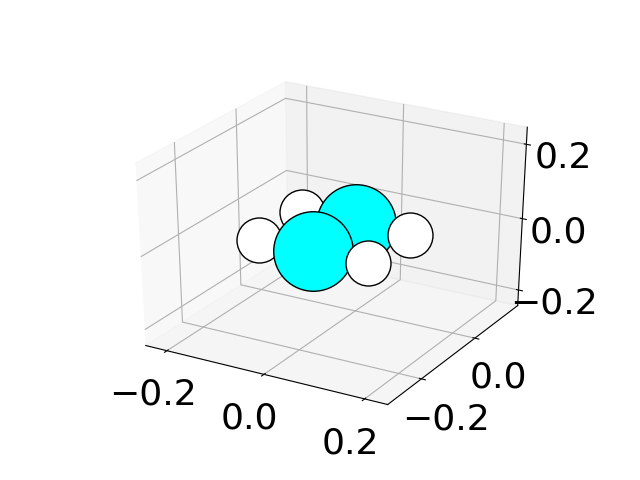

In [12]:
visualize(alkane)

It would be cumbersome to have to create `Compounds` by hand each time we wanted to use them. Instead, mBuild is intended to be used in such a way that reusable classes are defined for various `Compounds`. Here, we'll define a class for our CH2 moeity.

In [13]:
class CH2(mb.Compound):
    def __init__(self):
        super(CH2, self).__init__()
        mb.load('ch2.pdb', compound=self)
        carbon = list(self.particles_by_name('C'))[0]
        self.add(mb.Port(anchor=carbon, orientation=[0, 1, 0], separation=0.07), 'up')
        self.add(mb.Port(anchor=carbon, orientation=[0, -1, 0], separation=0.07), 'down')

If we instantiate this class and visualize we should see the same result we obtained earlier.

<IPython.core.display.Javascript object>


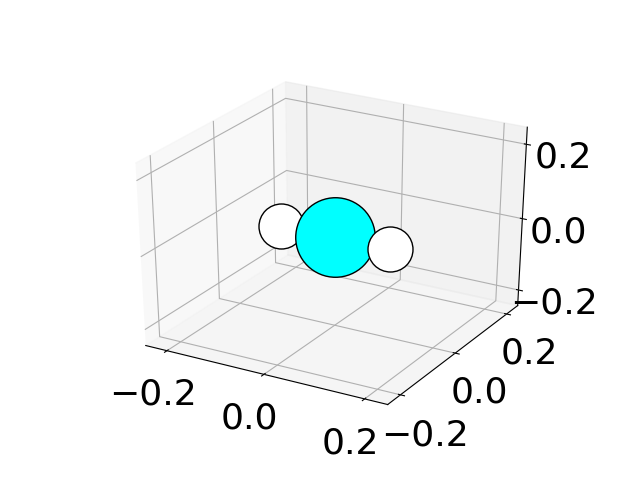

In [14]:
ch2 = CH2()
visualize(ch2)

Now that we have a class defined for our CH2 moeity, we can utilize this to create an alkane chain. Here we'll define a class for an alkane chain that can take `chain_length` as an argument. We will achieve this by successively adding CH2 moeities, and capping the first and last moieties with hydrogen atoms.

In [15]:
from mbuild.lib.atoms import H

class Alkane(mb.Compound):
    def __init__(self, chain_length=1):
        super(Alkane, self).__init__()
        last_monomer = CH2()
        hydrogen = H()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=last_monomer['up'])
        self.add(last_monomer)
        self.add(hydrogen)
        for _ in range(chain_length-1):
            current_monomer = CH2()
            mb.force_overlap(move_this=current_monomer,
                             from_positions=current_monomer['up'],
                             to_positions=last_monomer['down'])
            self.add(current_monomer)
            last_monomer=current_monomer
        hydrogen = H()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=last_monomer['down'])
        self.add(hydrogen)

Now that we've created an `Alkane` class, we can instantiate this and provide any chain length (>0) that we want.

<IPython.core.display.Javascript object>


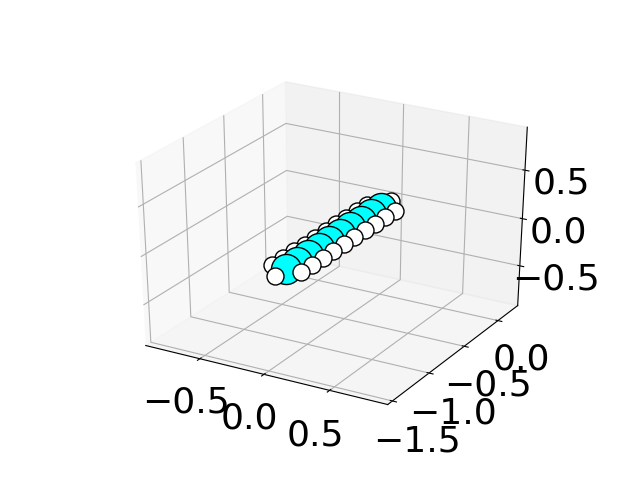

In [16]:
alkane = Alkane(10)
visualize(alkane)

One downside to creating compounds in this manner is that you often end up with non-realistic molecular configurations (such as the alkane above with all angles at 180 degrees). This is typically easily resolved through an initial energy minimization of the system you create in whichever simulation package you are using. However, mBuild also offers a built-in energy minimization routine that will attempt to optimize a `Compounds` geometry.

/Users/summeraz/mbuild/mbuild/compound.py:1241: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the UFF force field
  "Open Babel and the {} force field".format(forcefield))
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2108: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2110: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


<IPython.core.display.Javascript object>


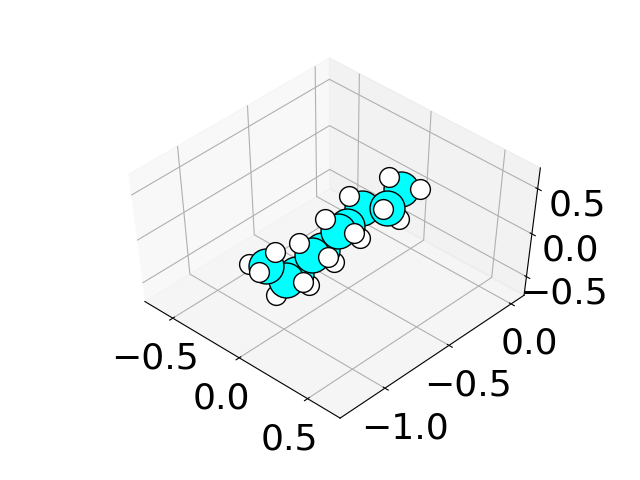

In [17]:
alkane.energy_minimization(steps=5000)
visualize(alkane)

mBuild also provides a `Polymer` recipe that essentially performs the same operations as the `Alkane` class we've defined above, but provides additional flexibility to support arbitrary monomer units as well as copolymers. Here we'll redefine our `Alkane` class to use the `Polymer` recipe.

In [18]:
class Alkane(mb.Compound):
    def __init__(self, chain_length=1):
        super(Alkane, self).__init__()
        chain = mb.Polymer(CH2(), chain_length)
        self.add(chain, label='chain')
        hydrogen = H()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=chain['up'])
        self.add(hydrogen, label='up-cap')
        hydrogen = H()
        mb.force_overlap(move_this=hydrogen,
                         from_positions=hydrogen['up'],
                         to_positions=chain['down'])
        self.add(hydrogen, label='down-cap')

<IPython.core.display.Javascript object>


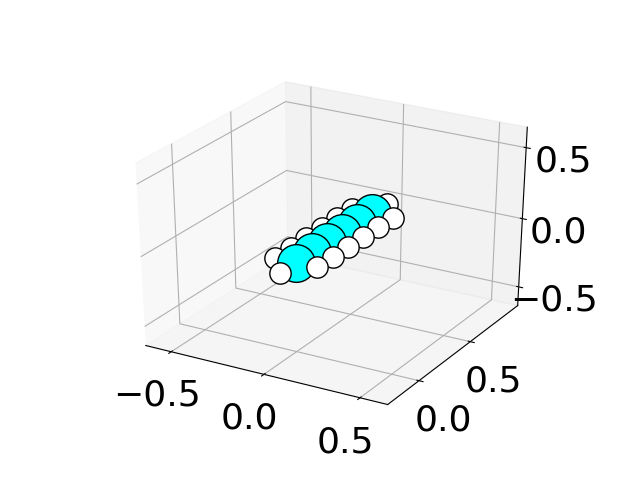

In [19]:
alkane = Alkane(6)
visualize(alkane)

Particles can be easily added and removed in mBuild. Here, we'll explore this functionality by turning our hexane molecule into hexanol.

First, we'll create a class for a hydroxyl group.

In [20]:
class OH(mb.Compound):
    def __init__(self):
        super(OH, self).__init__()
        self.add(mb.Particle(name='O', pos=[0.0, 0.0, 0.0]), label='O')
        self.add(mb.Particle(name='H', pos=[0.0, 0.1, 0.0]), label='H')
        self.add_bond((self['O'], self['H']))
        self.add(mb.Port(anchor=self['O'], orientation=[0, -1, 0], separation=0.075), label='down')

Let's visualize to see if everything looks good.

<IPython.core.display.Javascript object>


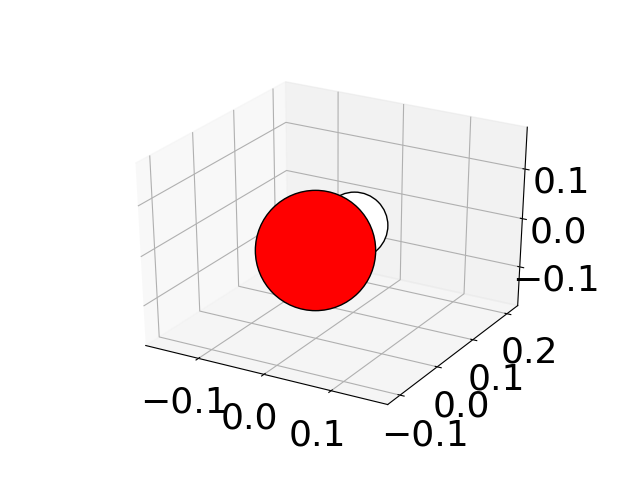

In [21]:
hydroxyl = OH()
visualize(hydroxyl)

Now we'll remove a hydrogen from one end of our hexane and add a hydroxyl.

In [22]:
alkane.remove(alkane['up-cap'])
mb.force_overlap(move_this=hydroxyl,
                 from_positions=hydroxyl['down'],
                 to_positions=alkane['chain']['up'])
hexanol = mb.Compound()
hexanol.add(alkane, label='alkane')
hexanol.add(hydroxyl, label='hydroxyl')

We can now visualize to make sure our hexanol was successfully created.

<IPython.core.display.Javascript object>


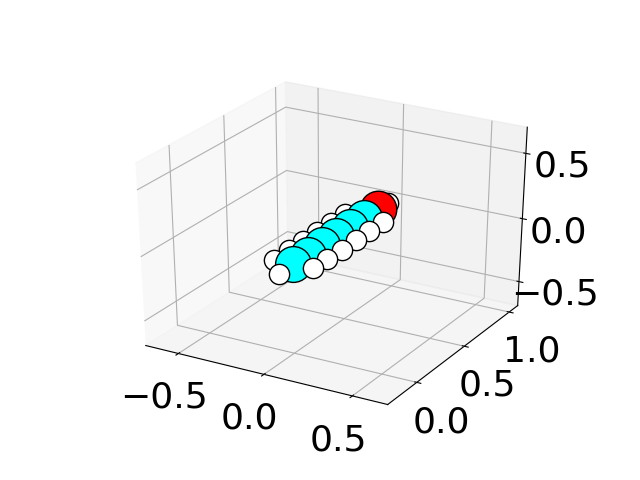

In [23]:
visualize(hexanol)

Running simulations of a single small molecule would likely not be very interesting. mBuild offers several routines to help create more complex systems. One of these routines is the `fill_box` function, which can be used to fill a box of a user-defined size with a specified number of molecules. We'll check this out now by placing 10 hexanols in a 3nm x 3nm x 3nm box.

<IPython.core.display.Javascript object>


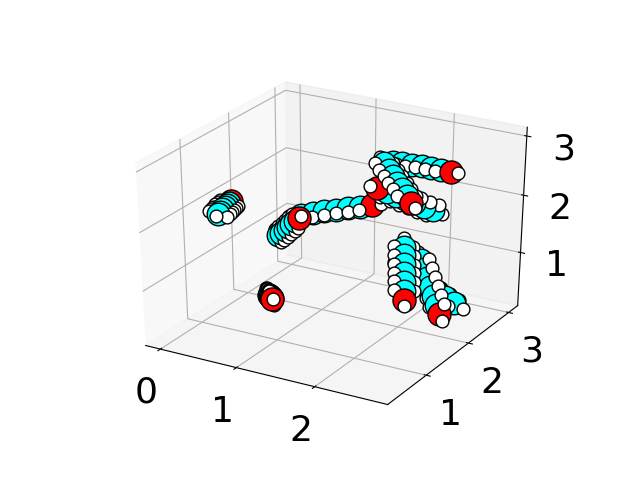

In [24]:
box = mb.fill_box(hexanol, n_compounds=10, box=[3, 3, 3])
visualize(box)

Now if we wanted to actually run a simulation of this system we would need to apply a force field and write the necessary data files. mBuild handles all of this through a single `save` command, where we can pass as arguments the name of the force field to apply (which uses Foyer under the hood) and the name of the file to create, which will be formatted based on the extension. Here we will save in Gromacs .top and .gro formats.

In [29]:
box.save('system.top', forcefield_name='oplsaa')
box.save('system.gro')

/Users/summeraz/foyer/foyer/validator.py:159: ValidationWarning: The following atom types do not have smarts definitions: opls_001, opls_002, opls_003, opls_004, opls_005, opls_006, opls_007, opls_008, opls_009, opls_010, opls_011, opls_012, opls_013, opls_014, opls_015, opls_016, opls_017, opls_018, opls_019, opls_020, opls_021, opls_022, opls_023, opls_024, opls_025, opls_026, opls_027, opls_028, opls_029, opls_030, opls_031, opls_032, opls_033, opls_034, opls_035, opls_036, opls_037, opls_038, opls_039, opls_040, opls_041, opls_042, opls_043, opls_044, opls_045, opls_046, opls_047, opls_048, opls_049, opls_050, opls_051, opls_052, opls_053, opls_054, opls_055, opls_056, opls_057, opls_058, opls_059, opls_060, opls_061, opls_062, opls_063, opls_064, opls_065, opls_066, opls_067, opls_068, opls_069, opls_070, opls_071, opls_072, opls_073, opls_074, opls_075, opls_076, opls_077, opls_078, opls_079, opls_080, opls_081, opls_082, opls_083, opls_084, opls_085, opls_086, opls_087, opls_088

The last bit of functionality we will check out is how to attach molecules to a surface. In our case here, we first need to remove the hydrogen atom opposite of the hydroxyl so that we have an available port on our hexanol to attach to a surface.

In [25]:
hexanol.remove(hexanol['alkane']['down-cap'])
hexanol.add(hexanol['alkane']['chain']['down'], 'down', containment=False)

The surface we will attach our hexanes to is crystalline silica, which we will import from mBuild's compound library. In many cases it is desirable to expand `Compounds` with periodicity, like surfaces, in one or more dimensions. mBuild features a built-in routine, `TiledCompound` to handle this functionality. Here we will use `TiledCompound` to expand our surface in the *x* dimension.

In [26]:
from mbuild.lib.surfaces import Betacristobalite
surface = Betacristobalite()
tiled_surface = mb.TiledCompound(surface, n_tiles=(2, 1, 1))

/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2108: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2110: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


mBuild contains a `Pattern` class which can be used to create patterns to place molecules at desired locations in space. This is useful for many cases, including defining the arrangement of chains on a surface. Here, we will create a `Random2DPattern` of 10 points in *xy* space.

The `Pattern.apply_to_compound` method can be used to attach `Compounds` to another `Compound` (e.g. a surface) by finding the vacant ports in the `host` `Compounds` closest to those defined by the pattern. Additionally, a `backfill` can be defined that will fill any leftover ports. Here, we will define a hydrogen atom as our backfill.

In [27]:
pattern = mb.Random2DPattern(10)
hydrogen = H()
chains, backfills = pattern.apply_to_compound(guest=hexanol, host=tiled_surface, backfill=hydrogen)

Finally, we'll add our surface, chains, and backfills to a parent `Compound` and visualize.

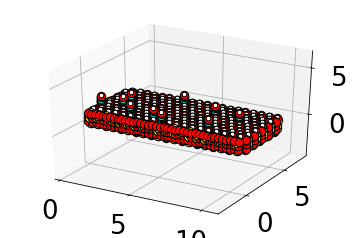

In [28]:
%matplotlib inline

functionalized_surface = mb.Compound()
for part in [tiled_surface, chains, backfills]:
    functionalized_surface.add(part)
visualize(functionalized_surface)